In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import torch
import time
import os
import re

In [2]:
torch.manual_seed(256)
torch.cuda.manual_seed(256)
np.random.seed(256)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cpu device.


## 2.1 Word embedding

1. Read txt files and tokenize them to obtain train/validation/test lists of words.

In [4]:
TOKENIZER = get_tokenizer("basic_english")


def read_txt_files(datapath):
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]

    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines


def tokenize(lines, tokenizer=TOKENIZER):
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text


def yield_tokens(lines, tokenizer=TOKENIZER):
    no_digits = "\w*[0-9]+\w*"  # Regex to match words containing numbers
    no_names = "\w*[A-Z]+\w*"  # Regex to match words with capital letters (names)
    no_spaces = "\s+"  # Regex to match sequences of whitespace

    # Processing each line to remove digits, names, and extra spaces
    for line in lines:
        line = re.sub(no_digits, " ", line)
        line = re.sub(no_names, " ", line)
        line = re.sub(no_spaces, " ", line)
        # Yielding the tokenized and cleaned line
        yield tokenizer(line)

In [5]:
def ensure_directory_exists(folder):
    """Creates the directory if it does not exist."""
    os.makedirs(folder, exist_ok=True)

In [6]:
GENERATED_PATH = "./generated/"  # Path where generated data files are stored
ensure_directory_exists(GENERATED_PATH)

# Check if the training data file already exists in the generated path
if os.path.isfile(GENERATED_PATH + "words_train.pt"):
    # Load preprocessed training, validation, and test word lists from .pt files
    words_train = torch.load(GENERATED_PATH + "words_train.pt")
    words_val = torch.load(GENERATED_PATH + "words_val.pt")
    words_test = torch.load(GENERATED_PATH + "words_test.pt")
else:
    # If preprocessed data does not exist, read text files
    lines_books_train = read_txt_files("data/data_train/")
    lines_books_val = read_txt_files("data/data_val/")
    lines_books_test = read_txt_files("data/data_test/")

    # Tokenize the lines from train, validation, and test datasets
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)

    # Save the tokenized word lists to .pt files
    torch.save(words_train, GENERATED_PATH + "words_train.pt")
    torch.save(words_val, GENERATED_PATH + "words_val.pt")
    torch.save(words_test, GENERATED_PATH + "words_test.pt")

2. Define a vocabulary based on the training dataset. To avoid getting a too large vocabulary, a solution can be to keep only words that appear at least 100 times in the training dataset. Report the total number of words in the training dataset, the number of distinct words in the training dataset, and the size of the defined vocabulary. Comment on your results.

In [7]:
MIN_FREQ = 100


def create_vocabulary(lines, min_freq=MIN_FREQ):
    # Building vocabulary from an iterator of tokenized lines, filtering out infrequent tokens
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq,
                                      specials=["<unk>", ",", ".", "(", ")", "?", "!"])
    # Appending token "I", since we removed all words with an uppercase when building the vocabulary
    vocab.append_token("i")
    # Setting default index for unknown words
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [8]:
VOCAB_FILENAME = "vocabulary.pt"

# Check if the vocabulary file already exists in the generated path
if os.path.isfile(GENERATED_PATH + VOCAB_FILENAME):
    # Load the vocabulary from a file if it already exists
    vocab = torch.load(GENERATED_PATH + VOCAB_FILENAME)
else:
    # If the vocabulary file does not exist, create a new vocabulary from training data
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    # Save the newly created vocabulary to a file
    torch.save(vocab, GENERATED_PATH + VOCAB_FILENAME)

VOCAB_SIZE = len(vocab)

In [9]:
print(f"Total number of words in the training dataset: {len(words_train):,}")
print(f"Total number of words in the validation dataset: {len(words_val):,}")
print(f"Total number of words in the test dataset: {len(words_test):,}", end="\n\n")

print(f"Number of distinct words in the training dataset: {len(set(words_train)):,}")
print(f"Number of distinct words in the validation dataset: {len(set(words_val)):,}")
print(f"Number of distinct words in the test dataset: {len(set(words_test)):,}", end="\n\n")

print(f"Size of the defined vocabulary: {VOCAB_SIZE:,}")

Total number of words in the training dataset: 2,684,706
Total number of words in the validation dataset: 49,526
Total number of words in the test dataset: 124,152

Number of distinct words in the training dataset: 52,105
Number of distinct words in the validation dataset: 5,778
Number of distinct words in the test dataset: 9,585

Size of the defined vocabulary: 1,880


In [10]:
def count_occurrences(words, vocab):
    occurrences = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        occurrences[vocab[w]] += 1
    return occurrences

In [11]:
word_counts_df = pd.DataFrame({
    "Word": vocab.lookup_tokens(range(len(vocab))),
    "Occurrences": count_occurrences(words_train, vocab).numpy()
})

sorted_word_counts = word_counts_df.sort_values(by="Occurrences", ascending=False).reset_index(drop=True)
sorted_word_counts.index = sorted_word_counts.index + 1

In [12]:
sorted_word_counts

,Word,Occurrences
1,<unk>,433907
2,",",182537
3,the,151278
4,.,123727
5,and,82289
...,...,...
1876,pistol,100
1877,slipped,100
1878,station-master,100
1879,wounds,100


In [13]:
CONTEXT_SIZE = 3  # Number of words considered before and after the target word


def create_context_target_dataset(text, vocab, context_size=CONTEXT_SIZE):
    contexts = []
    targets = []

    for i in range(context_size, len(text) - context_size):
        target = text[i]
        target_idx = vocab[target]

        context = [vocab[text[j]] for j in range(i - context_size, i + context_size + 1) if j != i]

        targets.append(target_idx)
        contexts.append(torch.tensor(context))

    return TensorDataset(torch.stack(contexts), torch.tensor(targets))

# def create_context_target_dataset(text, vocab, context_size=CONTEXT_SIZE, max_occurrences=None):
#     target_counts = {}
#     contexts = []
#     targets = []
# 
#     # Loop over the words list with enough space to form the context window
#     for i in range(context_size, len(text) - context_size):
#         target_word = text[i]
# 
#         # Skip if the target word is punctuation
#         if target_word in [',', '.', '(', ')', '?', '!']:
#             continue
# 
#         # Convert the word to its vocabulary index, skip if not in vocabulary
#         target_idx = vocab.get_stoi().get(target_word, None)
#         if target_idx is None:
#             continue
# 
#         # Limit occurrences of each word
#         if max_occurrences is not None:
#             if target_word in target_counts and target_counts[target_word] >= max_occurrences:
#                 continue
#             target_counts[target_word] = target_counts.get(target_word, 0) + 1
# 
#         # Extract the context words: context_size words before and context_size words after the target word
#         context = [vocab[text[j]] for j in range(i - context_size, i + context_size + 1) if j != i]
#         contexts.append(torch.tensor(context))
#         targets.append(target_idx)
# 
#     return TensorDataset(torch.stack(contexts), torch.tensor(targets, dtype=torch.long))

In [14]:
def load_dataset(words, vocab, filename, generated_path=GENERATED_PATH):
    full_path = os.path.join(generated_path, filename)
    if os.path.isfile(full_path):
        return torch.load(full_path)
    else:
        dataset = create_context_target_dataset(words, vocab)
        torch.save(dataset, full_path)
        return dataset


data_train = load_dataset(words_train, vocab, "data_train.pt")
data_val = load_dataset(words_val, vocab, "data_val.pt")
data_test = load_dataset(words_test, vocab, "data_test.pt")

In [15]:
print(f"Training dataset size: {len(data_train):,}")
print(f"Validation dataset size: {len(data_val):,}")
print(f"Test dataset size: {len(data_test):,}")

Training dataset size: 2,684,700
Validation dataset size: 49,520
Test dataset size: 124,146


In [16]:
BATCH_SIZE = 128

train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

3. Define a continuous bag of words model architecture based on this vocabulary that contains an embedding layer. To drastically reduce the computational cost, the dimension of the embedding `emb_dim` can be very low such as 16, 12, or even 10. Of course, in a real setting, a larger space would be used. You are not allowed to use `nn.LazyLinear` in this project.

https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [17]:
class CBOW(nn.Module):
    def __init__(self, emb_dim, hidden_dim, vocab_size=VOCAB_SIZE):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(emb_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        out = self.embedding(x).sum(dim=1)
        out = self.lin1(out)
        out = self.relu(out)
        out = self.lin2(out)
        return out

In [18]:
def train_model(model, train_loader, optimizer, loss_fn, epochs):
    training_losses = []
    training_times = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        start_time = time.time()

        for contexts, targets in train_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(contexts)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        end_time = time.time()
        epoch_duration = end_time - start_time
        training_times.append(epoch_duration)

        timestamp = datetime.now().strftime('%H:%M:%S.%f')
        print(f"{timestamp} | Epoch {epoch} | Training Loss: {avg_train_loss:.5f}")

    return training_losses, training_times

In [19]:
def calculate_weights(data, num_classes):
    # Initialize counts with zeros for each possible word index
    counts = torch.zeros(num_classes, dtype=torch.int)

    # Count occurrences of each word in the dataset
    for word in data:
        word_idx = vocab[word]
        counts[word_idx] += 1

    # Total number of samples
    total_samples = len(data)

    # Weights for each class
    weights = total_samples / (counts * num_classes)

    # Normalize weights so that their maximum is 1
    # weights = weights / weights.max()

    return weights.to(device)

In [20]:
CBOW_class_weights = calculate_weights(words_train, num_classes=VOCAB_SIZE)

In [21]:
def save_training_data(data, data_type, model_name):
    ensure_directory_exists(data_type)
    filepath = os.path.join(data_type, f"{model_name}_{data_type}.csv")
    df = pd.DataFrame({f"train_{data_type}": data})
    df.to_csv(filepath, index=False)

In [22]:
def load_training_data(data_type, model_name):
    filepath = os.path.join(data_type, f"{model_name}_{data_type}.csv")
    df = pd.read_csv(filepath)
    return df[f"train_{data_type}"].tolist()

In [23]:
def save_model(model, model_name, folder="models"):
    ensure_directory_exists(folder)
    filepath = os.path.join(folder, f"{model_name}.pth")
    torch.save(model.state_dict(), filepath)

In [24]:
def load_model(model, model_name, folder="models"):
    filepath = os.path.join(folder, f"{model_name}.pth")
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    return model

In [25]:
CBOW_configs = [
    {'emb_dim': 10, 'hidden_dim': 64, 'learning_rate': 1e-3, 'model_name': 'CBOW_model_emb10_hidden64_lr1e-3'},
    {'emb_dim': 16, 'hidden_dim': 64, 'learning_rate': 1e-4, 'model_name': 'CBOW_model_emb16_hidden64_lr1e-4'},
    {'emb_dim': 10, 'hidden_dim': 128, 'learning_rate': 1e-4, 'model_name': 'CBOW_model_emb10_hidden128_lr1e-4'},
    {'emb_dim': 20, 'hidden_dim': 128, 'learning_rate': 1e-5, 'model_name': 'CBOW_model_emb20_hidden128_lr1e-5'},
    {'emb_dim': 64, 'hidden_dim': 128, 'learning_rate': 1e-5, 'model_name': 'CBOW_model_emb64_hidden128_lr1e-5'},
    {'emb_dim': 84, 'hidden_dim': 128, 'learning_rate': 1e-5, 'model_name': 'CBOW_model_emb84_hidden128_lr1e-5'},
    {'emb_dim': 64, 'hidden_dim': 256, 'learning_rate': 1e-4, 'model_name': 'CBOW_model_emb64_hidden256_lr1e-4'},
    {'emb_dim': 128, 'hidden_dim': 128, 'learning_rate': 1e-4, 'model_name': 'CBOW_model_emb128_hidden128_lr1e-4'},
    {'emb_dim': 64, 'hidden_dim': 128, 'learning_rate': 1e-3, 'model_name': 'CBOW_model_emb64_hidden128_lr1e-3'}
]

In [26]:
def train_and_save_models(configs, model_constructor, train_loader, trained_embeddings=None, class_weights=None):
    for config in configs:
        torch.manual_seed(256)
        torch.cuda.manual_seed(256)
        np.random.seed(256)

        if model_constructor == CBOW:
            model = model_constructor(emb_dim=config['emb_dim'], hidden_dim=config['hidden_dim']).to(device)
        elif model_constructor == SimpleMLP:
            model = model_constructor(trained_embeddings, emb_dim=trained_embeddings.shape[1],
                                      hidden_dim=config['hidden_dim']).to(device)
        elif model_constructor == MLPWithAttention:
            model = model_constructor(trained_embeddings, emb_dim=trained_embeddings.shape[1],
                                      hidden_dim=config['hidden_dim']).to(device)
        elif model_constructor == SimpleRNN:
            model = model_constructor(trained_embeddings, emb_dim=trained_embeddings.shape[1],
                                      hidden_dim=config['hidden_dim'], num_layers=config['num_layers']).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

        loss_fn = nn.CrossEntropyLoss(weight=class_weights)

        print(f"Training {config['model_name']}:")
        training_losses, training_times = train_model(model, train_loader, optimizer, loss_fn, epochs=20)

        save_model(model, config['model_name'])
        save_training_data(training_losses, "losses", config['model_name'])
        save_training_data(training_times, "times", config['model_name'])

In [ ]:
train_and_save_models(CBOW_configs, CBOW, train_loader)

In [85]:
def plot_losses(model_names):
    cmap = plt.get_cmap("Paired")

    for i, model_name in enumerate(model_names):
        losses = load_training_data("losses", model_name)
        plt.plot(range(1, len(losses) + 1), losses, label=model_name, color=cmap(i))

    plt.title("Model Training Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.xticks(range(0, len(losses) + 1, 5))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Model Names")
    plt.grid(color='silver', linestyle='--', linewidth=0.5)
    plt.show()

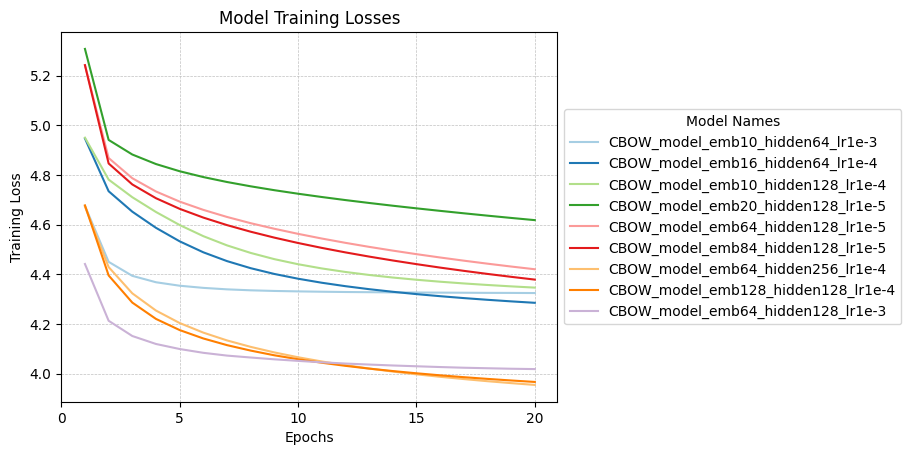

In [86]:
plot_losses([config['model_name'] for config in CBOW_configs])

4. Train several models, select the best one, and evaluate its performance. Note that the performance here is potentially extremely low, but the real objective is not to train a good predictor, only to have a good representation of the semantics of each word in the vocabulary.

In [65]:
def accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for contexts, targets in data_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

In [66]:
def load_and_evaluate_models(configurations, model_constructor, val_loader, trained_embeddings=None):
    best_model = None
    best_model_name = ""
    best_accuracy = 0

    print("Evaluating configurations...")
    print("-" * 80)
    print("{:<40} | {:<40}".format("Model Configuration", "Validation Accuracy"))
    print("-" * 80)

    for config in configurations:
        if model_constructor == CBOW:
            model = model_constructor(emb_dim=config['emb_dim'], hidden_dim=config['hidden_dim']).to(device)
        elif model_constructor == SimpleMLP:
            model = model_constructor(trained_embeddings, emb_dim=trained_embeddings.shape[1],
                                      hidden_dim=config['hidden_dim']).to(device)
        elif model_constructor == MLPWithAttention:
            model = model_constructor(trained_embeddings, emb_dim=trained_embeddings.shape[1],
                                      hidden_dim=config['hidden_dim']).to(device)
        elif model_constructor == SimpleRNN:
            model = model_constructor(trained_embeddings, emb_dim=trained_embeddings.shape[1],
                                      hidden_dim=config['hidden_dim'], num_layers=config['num_layers']).to(device)

        model = load_model(model, config['model_name'])

        val_accuracy = accuracy(model, val_loader)
        print("{:<40} | {:<40.2%}".format(config['model_name'], val_accuracy))

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_model_name = config['model_name']

    print("-" * 80)

    return best_model, best_model_name, best_accuracy

In [67]:
best_CBOW_model, best_CBOW_model_name, best_CBOW_val_accuracy = load_and_evaluate_models(CBOW_configs, CBOW, val_loader)
print(f"Validation Accuracy of the best CBOW model ({best_CBOW_model_name}): {best_CBOW_val_accuracy:.2%}")

Evaluating configurations...
--------------------------------------------------------------------------------
Model Configuration                      | Validation Accuracy                     
--------------------------------------------------------------------------------
CBOW_model_emb10_hidden64_lr1e-3         | 19.71%                                  
CBOW_model_emb16_hidden64_lr1e-4         | 19.95%                                  
CBOW_model_emb10_hidden128_lr1e-4        | 19.35%                                  
CBOW_model_emb20_hidden128_lr1e-5        | 17.26%                                  
CBOW_model_emb64_hidden128_lr1e-5        | 18.78%                                  
CBOW_model_emb84_hidden128_lr1e-5        | 18.85%                                  
CBOW_model_emb64_hidden256_lr1e-4        | 22.35%                                  
CBOW_model_emb128_hidden128_lr1e-4       | 22.12%                                  
CBOW_model_emb64_hidden128_lr1e-3        | 21.90%    

In [68]:
CBOW_test_accuracy = accuracy(best_CBOW_model, test_loader)
print(f"Test Accuracy of the best CBOW model ({best_CBOW_model_name}): {CBOW_test_accuracy:.2%}")

Test Accuracy of the best CBOW model (CBOW_model_emb64_hidden256_lr1e-4): 25.09%


5. Compute the cosine similarity matrix of the vocabulary based on the trained embedding. For some words of your choice (e.g. *me*, *white*, *man*, *have*, *be*, *child*, *yes*, *what* etc.), report the 10 most similar words. Comment on your results.

In [69]:
best_model_embeddings = best_CBOW_model.embedding.weight.detach().cpu().numpy()

mat_size = len(best_model_embeddings)
cos_sim_mat = np.zeros(shape=(mat_size, mat_size))

for w1 in range(mat_size):
    for w2 in range(mat_size):
        cos_sim_mat[w1][w2] = np.dot(best_model_embeddings[w1], best_model_embeddings[w2]) / (
                np.linalg.norm(best_model_embeddings[w1]) * np.linalg.norm(best_model_embeddings[w2]))

In [70]:
test_words = ["me", "white", "man", "have", "be", "child", "yes", "what"]
test_words_idx = [vocab.get_stoi()[word] for word in test_words]

In [71]:
top_n = 10
similar_words = {}

for word, idx in zip(test_words, test_words_idx):
    # get cosine similarities for the current word against all other words
    similarities = cos_sim_mat[idx]

    # get indices of the top 10 most similar words (excluding the word itself)
    # argsort returns indices of sorted array, with the smallest first, so we take the last 10 items
    most_similar_idxs = np.argsort(similarities)[-top_n - 1:-1][::-1]

    # map indices back to words
    similar_words[word] = [vocab.get_itos()[i] for i in most_similar_idxs]

In [72]:
for word, similar in similar_words.items():
    print(f"Words most similar to '{word}': {similar}")

Words most similar to 'me': ['us', 'him', 'thee', 'you', 'replies', 'courage', 'truth', 'wished', 'frightful', 'mon']
Words most similar to 'white': ['blue', 'red', 'foliage', 'creature', 'warm', 'yellow', 'glass', 'spirit', 'smiling', 'shadows']
Words most similar to 'man': ['woman', 'lady', 'girl', 'soldier', 'person', 'general', 'figure', 'prince', 'fellow', 'mystery']
Words most similar to 'have': ['ve', 'had', 'having', 'stand', 'has', 'ask', 'act', 'reach', 'call', 'hundred']
Words most similar to 'be': ['happen', 'being', 'been', 'find', 'lie', 'stand', 'prevent', 'remain', 'help', 'avoid']
Words most similar to 'child': ['mother', 'husband', 'colonel', 'driver', 'wolf', 'not', 'conversation', 'princess', 'lad', 'creature']
Words most similar to 'yes': ['sir', 'indeed', 'replies', 'cross', 'repeated', 'tomorrow', 'exclaimed', 'nonsense', 'nose', 'yours']
Words most similar to 'what': ['halted', 'something', 'seated', 'how', 'why', 'wish', 'unless', 'staff', 'la', 'useful']


6. Visualize the embedding space on <https://projector.tensorflow.org>. To do so, upload the vocabulary and their corresponding values in the embedding space as two tsv files. Try to find and select clusters. Report both plots (you can use screenshots) and their corresponding selections for some meaningful clusters. Comment on your results.

In [73]:
tf_projector_folder_path = "tensorflow_projector"
ensure_directory_exists(tf_projector_folder_path)

df_embeddings = pd.DataFrame(best_model_embeddings)
df_embeddings.to_csv("tensorflow_projector/vectors.tsv", sep="\t", header=False, index=False)

vocab_items = vocab.get_itos()
df_vocab = pd.DataFrame(vocab_items)
df_vocab.to_csv("tensorflow_projector/metadata.tsv", sep="\t", header=False, index=False)

## 2.2 Conjugating *be* and *have*

To predict be and have conjugation, the (contexts, targets) datasets must be such that the targets are *be*, *am*, *are*, *is*, *was*, *were*, *been*, *being*, *have*, *has*, *had*, *having*. The output layer must match the number of classes to predict and the labels must be mapped from their original index in the vocabulary to integers between 0 and 11.

In [74]:
CONJUGATIONS = {target: i for i, target in enumerate([
    "be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"
])}


def create_conjugation_dataset(text, vocab, context_size=CONTEXT_SIZE):
    contexts = []
    targets = []

    for i in range(context_size, len(text) - context_size):
        target_word = text[i]
        if target_word in CONJUGATIONS:
            target_idx = CONJUGATIONS[target_word]

            context = [vocab[text[j]] for j in range(i - context_size, i + context_size + 1) if j != i]
            contexts.append(torch.tensor(context))
            targets.append(target_idx)

    return TensorDataset(torch.stack(contexts), torch.tensor(targets, dtype=torch.long))

In [75]:
def load_conjugation_dataset(words, vocab, filename, generated_path=GENERATED_PATH):
    full_path = os.path.join(generated_path, filename)
    if os.path.isfile(full_path):
        return torch.load(full_path)
    else:
        dataset = create_conjugation_dataset(words, vocab)
        torch.save(dataset, full_path)
        return dataset


data_train_conj = load_conjugation_dataset(words_train, vocab, "data_train_conj.pt")
data_val_conj = load_conjugation_dataset(words_val, vocab, "data_val_conj.pt")
data_test_conj = load_conjugation_dataset(words_test, vocab, "data_test_conj.pt")

In [76]:
print(f"Conjugation training dataset size: {len(data_train_conj):,}")
print(f"Conjugation validation dataset size: {len(data_val_conj):,}")
print(f"Conjugation test dataset size: {len(data_test_conj):,}")

Conjugation training dataset size: 124,030
Conjugation validation dataset size: 2,590
Conjugation test dataset size: 4,765


In [77]:
train_loader_conj = DataLoader(data_train_conj, batch_size=BATCH_SIZE, shuffle=True)
val_loader_conj = DataLoader(data_val_conj, batch_size=BATCH_SIZE, shuffle=False)
test_loader_conj = DataLoader(data_test_conj, batch_size=BATCH_SIZE, shuffle=False)

Your trained word embedding can be integrated in your next models in different ways. For example, you can transform inputs before feeding them to your models, or have a first layer in your models with the same weight values as your trained embedding matrix, or simply define the computations between the input and the embedding matrix in the forward function. In any case, make sure that your embedding layer doesn’t get updated when training the rest of your models!

In [78]:
trained_embeddings = best_CBOW_model.embedding.weight.data

In [79]:
OUTPUT_DIM = len(CONJUGATIONS)

In [80]:
class SimpleMLP(nn.Module):
    def __init__(self, embedding_matrix, emb_dim, hidden_dim, context_size=CONTEXT_SIZE, output_dim=OUTPUT_DIM):
        super(SimpleMLP, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lin1 = nn.Linear(context_size * 2 * emb_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)
        x = torch.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [81]:
SimpleMLP_configs = [
    {'hidden_dim': 64, 'learning_rate': 1e-3, 'model_name': 'SimpleMLP_model_hidden64_lr1e-3'},
    {'hidden_dim': 64, 'learning_rate': 1e-4, 'model_name': 'SimpleMLP_model_hidden64_lr1e-4'},
    {'hidden_dim': 64, 'learning_rate': 1e-5, 'model_name': 'SimpleMLP_model_hidden64_lr1e-5'},
    {'hidden_dim': 128, 'learning_rate': 1e-3, 'model_name': 'SimpleMLP_model_hidden128_lr1e-3'},
    {'hidden_dim': 128, 'learning_rate': 1e-4, 'model_name': 'SimpleMLP_model_hidden128_lr1e-4'},
    {'hidden_dim': 128, 'learning_rate': 1e-5, 'model_name': 'SimpleMLP_model_hidden128_lr1e-5'},
    {'hidden_dim': 256, 'learning_rate': 1e-3, 'model_name': 'SimpleMLP_model_hidden256_lr1e-3'},
    {'hidden_dim': 256, 'learning_rate': 1e-4, 'model_name': 'SimpleMLP_model_hidden256_lr1e-4'},
    {'hidden_dim': 256, 'learning_rate': 1e-5, 'model_name': 'SimpleMLP_model_hidden256_lr1e-5'}
]

In [82]:
train_and_save_models(SimpleMLP_configs, SimpleMLP, train_loader_conj, trained_embeddings)

Training SimpleMLP_model_hidden64_lr1e-3:
13:37:10.781509 | Epoch 1 | Training Loss: 1.16189
13:37:11.564056 | Epoch 2 | Training Loss: 1.00950
13:37:12.338020 | Epoch 3 | Training Loss: 0.97138
13:37:13.668822 | Epoch 4 | Training Loss: 0.94445
13:37:14.452118 | Epoch 5 | Training Loss: 0.92387
13:37:15.723774 | Epoch 6 | Training Loss: 0.90616
13:37:16.546009 | Epoch 7 | Training Loss: 0.89232
13:37:17.383668 | Epoch 8 | Training Loss: 0.88097
13:37:18.190577 | Epoch 9 | Training Loss: 0.87077
13:37:18.991946 | Epoch 10 | Training Loss: 0.86251
13:37:19.875532 | Epoch 11 | Training Loss: 0.85480
13:37:20.735229 | Epoch 12 | Training Loss: 0.84812
13:37:21.539006 | Epoch 13 | Training Loss: 0.84199
13:37:22.367788 | Epoch 14 | Training Loss: 0.83602
13:37:23.161983 | Epoch 15 | Training Loss: 0.83198
13:37:24.208758 | Epoch 16 | Training Loss: 0.82800
13:37:25.597347 | Epoch 17 | Training Loss: 0.82282
13:37:26.400303 | Epoch 18 | Training Loss: 0.81924
13:37:27.257121 | Epoch 19 | Tr

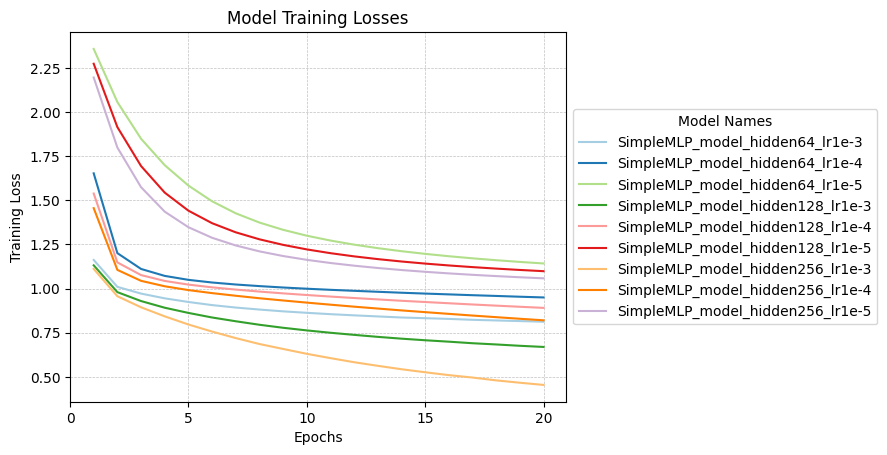

In [87]:
plot_losses([config['model_name'] for config in SimpleMLP_configs])

In [88]:
best_SimpleMLP_model, best_SimpleMLP_model_name, best_SimpleMLP_val_accuracy = load_and_evaluate_models(
    SimpleMLP_configs, SimpleMLP, val_loader_conj, trained_embeddings)
print(
    f"Validation Accuracy of the best SimpleMLP model ({best_SimpleMLP_model_name}): {best_SimpleMLP_val_accuracy:.2%}")

Evaluating configurations...
--------------------------------------------------------------------------------
Model Configuration                      | Validation Accuracy                     
--------------------------------------------------------------------------------
SimpleMLP_model_hidden64_lr1e-3          | 60.89%                                  
SimpleMLP_model_hidden64_lr1e-4          | 62.47%                                  
SimpleMLP_model_hidden64_lr1e-5          | 57.10%                                  
SimpleMLP_model_hidden128_lr1e-3         | 61.78%                                  
SimpleMLP_model_hidden128_lr1e-4         | 63.32%                                  
SimpleMLP_model_hidden128_lr1e-5         | 59.03%                                  
SimpleMLP_model_hidden256_lr1e-3         | 58.49%                                  
SimpleMLP_model_hidden256_lr1e-4         | 62.63%                                  
SimpleMLP_model_hidden256_lr1e-5         | 59.65%    

In [89]:
SimpleMLP_test_accuracy = accuracy(best_SimpleMLP_model, test_loader_conj)
print(f"Test Accuracy of the best SimpleMLP model ({best_SimpleMLP_model_name}): {SimpleMLP_test_accuracy:.2%}")

Test Accuracy of the best SimpleMLP model (SimpleMLP_model_hidden128_lr1e-4): 55.95%


Positional Encoding: <https://pytorch.org/tutorials/beginner/transformer_tutorial.html>

Self-Attention: <https://spotintelligence.com/2023/01/31/self-attention/>

<https://github.com/datnnt1997/multi-head_self-attention/blob/master/SelfAttention.ipynb>

<https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html>

<https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb>

<https://jalammar.github.io/illustrated-transformer/>

In [90]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, emb_dim):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, emb_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * -(np.log(10000.0) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # register matrix as a buffer that does not require gradients

    def forward(self, x):
        # word embeddings + positional encodings
        return x + self.pe[:, :x.size(1)]

In [91]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Make sure the embedding dimension can be evenly divided by the number of heads
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        # Calculate the size of each attention head
        self.dim_per_head = emb_dim // num_heads
        self.num_heads = num_heads

        # Weights for transforming inputs to queries, keys, and values
        self.W_q = nn.ModuleList([nn.Linear(emb_dim, self.dim_per_head, bias=False) for _ in range(num_heads)])
        self.W_k = nn.ModuleList([nn.Linear(emb_dim, self.dim_per_head, bias=False) for _ in range(num_heads)])
        self.W_v = nn.ModuleList([nn.Linear(emb_dim, self.dim_per_head, bias=False) for _ in range(num_heads)])

        # Final linear layer that will transform the concatenated outputs from all attention heads
        self.W_o = nn.Linear(emb_dim, emb_dim)

    def forward(self, x):
        # x: [N, max_len, emb_dim]

        N = x.size(0)

        # Apply linear transformations and reshape for multi-head attention computation
        qs = [l_q(x).view(N, -1, self.dim_per_head) for l_q in self.W_q]  # [N, max_len, dim_per_head]
        ks = [l_k(x).view(N, -1, self.dim_per_head) for l_k in self.W_k]
        vs = [l_v(x).view(N, -1, self.dim_per_head) for l_v in self.W_v]

        # Attention mechanism for each head
        # For each set of Q, K, V compute the scaled dot-product attention
        head_outputs = []
        for q, k, v in zip(qs, ks, vs):
            # Compute attention scores using matrix multiplication between queries and keys
            # The scores are scaled down by the square root of the size of each attention head (dim_per_head)
            attn_scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.dim_per_head)  # [N, max_len, max_len]

            # Softmax normalizes the scores so they’re all positive and add up to 1
            attn = F.softmax(attn_scores, dim=-1)  # [N, max_len, max_len]

            # Multiply softmax score with the values to get the weighted context vectors for each head
            head_outputs.append(torch.matmul(attn, v))  # [N, max_len, dim_per_head]

        # Concatenate the context vectors from all attention heads
        concat_heads = torch.cat(head_outputs, dim=-1)  # [N, max_len, emb_dim]

        # Pass the concatenated vectors through the final linear layer to get multi-head attention output
        output = self.W_o(concat_heads)  # [N, max_len, emb_dim]

        return output

In [92]:
class MLPWithAttention(nn.Module):
    def __init__(self, embedding_matrix, emb_dim, hidden_dim, num_heads=8,
                 max_len=CONTEXT_SIZE * 2, output_dim=OUTPUT_DIM):
        super(MLPWithAttention, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.pos_encoder = PositionalEncoding(max_len, emb_dim)
        self.attention = MultiHeadAttention(emb_dim, num_heads)
        self.fc1 = nn.Linear(emb_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # maps to conjugation classes

    def forward(self, x):
        x = self.embedding(x)  # Convert token indices to embeddings
        x = self.pos_encoder(x)  # Add positional encoding
        x = self.attention(x)  # Apply attention over the sequence
        x = x.mean(dim=1)  # Aggregate across the sequence dim
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Produce logits
        return x
        # return F.log_softmax(x, dim=1)

In [93]:
MLPWithAttention_configs = [
    {'hidden_dim': 64, 'learning_rate': 1e-3, 'model_name': 'MLPWithAttention_model_hidden64_lr1e-3'},
    {'hidden_dim': 64, 'learning_rate': 1e-4, 'model_name': 'MLPWithAttention_model_hidden64_lr1e-4'},
    {'hidden_dim': 64, 'learning_rate': 1e-5, 'model_name': 'MLPWithAttention_model_hidden64_lr1e-5'},
    {'hidden_dim': 128, 'learning_rate': 1e-3, 'model_name': 'MLPWithAttention_model_hidden128_lr1e-3'},
    {'hidden_dim': 128, 'learning_rate': 1e-4, 'model_name': 'MLPWithAttention_model_hidden128_lr1e-4'},
    {'hidden_dim': 128, 'learning_rate': 1e-5, 'model_name': 'MLPWithAttention_model_hidden128_lr1e-5'},
    {'hidden_dim': 256, 'learning_rate': 1e-3, 'model_name': 'MLPWithAttention_model_hidden256_lr1e-3'},
    {'hidden_dim': 256, 'learning_rate': 1e-4, 'model_name': 'MLPWithAttention_model_hidden256_lr1e-4'},
    {'hidden_dim': 256, 'learning_rate': 1e-5, 'model_name': 'MLPWithAttention_model_hidden256_lr1e-5'},
]

In [94]:
train_and_save_models(MLPWithAttention_configs, MLPWithAttention, train_loader_conj, trained_embeddings)

Training MLPWithAttention_model_hidden64_lr1e-3:
13:42:56.213346 | Epoch 1 | Training Loss: 1.27132
13:43:07.190102 | Epoch 2 | Training Loss: 1.09108
13:43:17.717040 | Epoch 3 | Training Loss: 1.05115
13:43:28.754793 | Epoch 4 | Training Loss: 1.02585
13:43:37.528479 | Epoch 5 | Training Loss: 1.00857
13:43:47.157165 | Epoch 6 | Training Loss: 0.99332
13:43:55.235902 | Epoch 7 | Training Loss: 0.98127
13:44:03.659090 | Epoch 8 | Training Loss: 0.97135
13:44:11.543393 | Epoch 9 | Training Loss: 0.96115
13:44:19.688985 | Epoch 10 | Training Loss: 0.95319
13:44:29.824836 | Epoch 11 | Training Loss: 0.94613
13:44:37.699122 | Epoch 12 | Training Loss: 0.93963
13:44:46.010122 | Epoch 13 | Training Loss: 0.93385
13:44:53.951714 | Epoch 14 | Training Loss: 0.92872
13:45:02.053347 | Epoch 15 | Training Loss: 0.92480
13:45:10.002280 | Epoch 16 | Training Loss: 0.91900
13:45:19.321174 | Epoch 17 | Training Loss: 0.91417
13:45:31.141189 | Epoch 18 | Training Loss: 0.91115
13:45:42.322416 | Epoch 

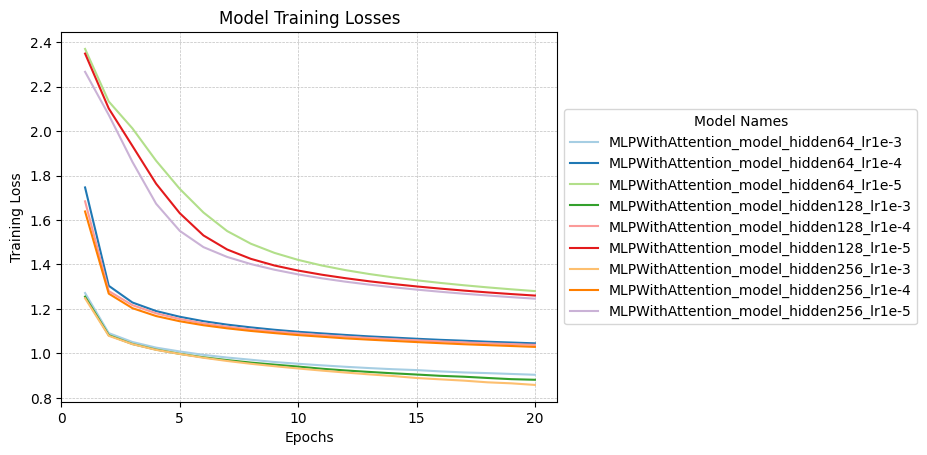

In [95]:
plot_losses([config['model_name'] for config in MLPWithAttention_configs])

In [96]:
best_MLPWithAttention_model, best_MLPWithAttention_model_name, best_MLPWithAttention_val_accuracy = load_and_evaluate_models(
    MLPWithAttention_configs, MLPWithAttention, val_loader_conj, trained_embeddings)
print(
    f"Validation Accuracy of the best MLPWithAttention model ({best_MLPWithAttention_model_name}): {best_MLPWithAttention_val_accuracy:.2%}")

Evaluating configurations...
--------------------------------------------------------------------------------
Model Configuration                      | Validation Accuracy                     
--------------------------------------------------------------------------------
MLPWithAttention_model_hidden64_lr1e-3   | 61.20%                                  
MLPWithAttention_model_hidden64_lr1e-4   | 58.22%                                  
MLPWithAttention_model_hidden64_lr1e-5   | 52.78%                                  
MLPWithAttention_model_hidden128_lr1e-3  | 61.97%                                  
MLPWithAttention_model_hidden128_lr1e-4  | 58.84%                                  
MLPWithAttention_model_hidden128_lr1e-5  | 53.01%                                  
MLPWithAttention_model_hidden256_lr1e-3  | 60.27%                                  
MLPWithAttention_model_hidden256_lr1e-4  | 58.19%                                  
MLPWithAttention_model_hidden256_lr1e-5  | 54.13%    

In [97]:
MLPWithAttention_test_accuracy = accuracy(best_MLPWithAttention_model, test_loader_conj)
print(
    f"Test Accuracy of the best MLPWithAttention model ({best_MLPWithAttention_model_name}): {MLPWithAttention_test_accuracy:.2%}")

Test Accuracy of the best MLPWithAttention model (MLPWithAttention_model_hidden128_lr1e-3): 54.77%


<https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/#steps_2>

<https://machinelearningmastery.com/text-generation-with-lstm-in-pytorch/>

In [98]:
class SimpleRNN(nn.Module):
    def __init__(self, embedding_matrix, emb_dim, hidden_dim, num_layers, output_dim=OUTPUT_DIM):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, _) = self.lstm(x)
        x = output[:, -1, :]  # get the output of the last time step
        x = self.fc(self.dropout(x))  # produce logits for each class
        return x

In [101]:
SimpleRNN_configs = [
    {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 1e-3, 'model_name': 'SimpleRNN_model_hidden64_nl1_lr1e-3'},
    {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 1e-4, 'model_name': 'SimpleRNN_model_hidden64_nl2_lr1e-4'},
    {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 1e-3, 'model_name': 'SimpleRNN_model_hidden128_nl1_lr1e-3'},
    {'hidden_dim': 128, 'num_layers': 2, 'learning_rate': 1e-4, 'model_name': 'SimpleRNN_model_hidden128_nl2_lr1e-4'},
]

In [102]:
train_and_save_models(SimpleRNN_configs, SimpleRNN, train_loader_conj, trained_embeddings)

Training SimpleRNN_model_hidden64_nl1_lr1e-3:
14:19:42.999699 | Epoch 1 | Training Loss: 1.32921
14:19:48.963367 | Epoch 2 | Training Loss: 1.08089
14:19:54.258466 | Epoch 3 | Training Loss: 1.02397
14:20:00.148515 | Epoch 4 | Training Loss: 0.98943
14:20:05.754539 | Epoch 5 | Training Loss: 0.96529
14:20:11.398021 | Epoch 6 | Training Loss: 0.94518
14:20:17.726885 | Epoch 7 | Training Loss: 0.93102
14:20:24.584220 | Epoch 8 | Training Loss: 0.91697
14:20:31.390332 | Epoch 9 | Training Loss: 0.90540
14:20:38.036151 | Epoch 10 | Training Loss: 0.89380
14:20:44.705168 | Epoch 11 | Training Loss: 0.88426
14:20:51.353439 | Epoch 12 | Training Loss: 0.87649
14:20:58.171016 | Epoch 13 | Training Loss: 0.86832
14:21:04.793345 | Epoch 14 | Training Loss: 0.86076
14:21:11.328177 | Epoch 15 | Training Loss: 0.85222
14:21:19.013979 | Epoch 16 | Training Loss: 0.84581
14:21:26.000635 | Epoch 17 | Training Loss: 0.83980
14:21:33.346190 | Epoch 18 | Training Loss: 0.83367
14:21:40.000175 | Epoch 19 

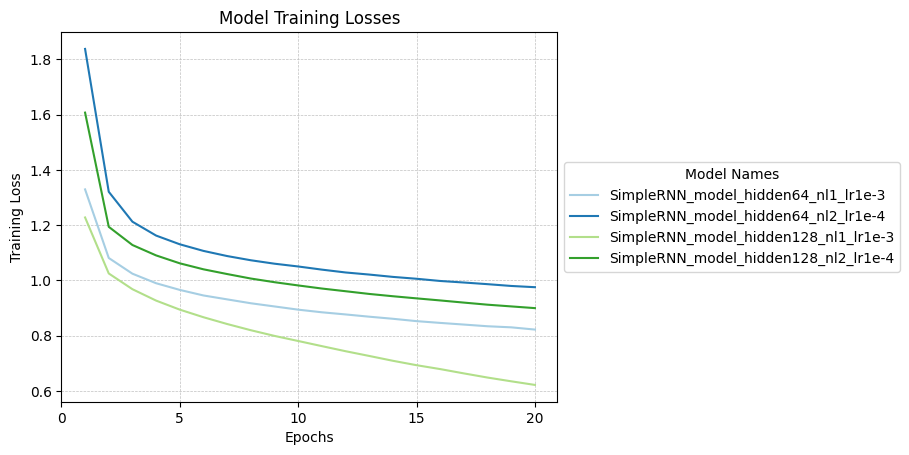

In [103]:
plot_losses([config['model_name'] for config in SimpleRNN_configs])

In [104]:
best_SimpleRNN_model, best_SimpleRNN_model_name, best_SimpleRNN_val_accuracy = load_and_evaluate_models(
    SimpleRNN_configs, SimpleRNN, val_loader_conj, trained_embeddings)
print(
    f"Validation Accuracy of the best SimpleRNN model ({best_SimpleRNN_model_name}): {best_SimpleRNN_val_accuracy:.2%}")

Evaluating configurations...
--------------------------------------------------------------------------------
Model Configuration                      | Validation Accuracy                     
--------------------------------------------------------------------------------
SimpleRNN_model_hidden64_nl1_lr1e-3      | 63.67%                                  
SimpleRNN_model_hidden64_nl2_lr1e-4      | 61.78%                                  
SimpleRNN_model_hidden128_nl1_lr1e-3     | 62.82%                                  
SimpleRNN_model_hidden128_nl2_lr1e-4     | 62.74%                                  
--------------------------------------------------------------------------------
Validation Accuracy of the best SimpleRNN model (SimpleRNN_model_hidden64_nl1_lr1e-3): 63.67%


In [105]:
SimpleRNN_test_accuracy = accuracy(best_SimpleRNN_model, test_loader_conj)
print(f"Test Accuracy of the best MLPWithAttention model ({best_SimpleRNN_model_name}): {SimpleRNN_test_accuracy:.2%}")

Test Accuracy of the best MLPWithAttention model (SimpleRNN_model_hidden64_nl1_lr1e-3): 56.35%


In [115]:
# extracting model names and compute their average training times, then organize and sort these in DataFrame
mlp_and_rnn_model_names = [config['model_name'] for config in SimpleMLP_configs + MLPWithAttention_configs +
                           SimpleRNN_configs]

mlp_and_rnn_average_times = []
for model_name in mlp_and_rnn_model_names:
    training_times = load_training_data("times", model_name)
    avg_time = np.array(training_times).mean()
    mlp_and_rnn_average_times.append((model_name, avg_time))

df_times = pd.DataFrame(mlp_and_rnn_average_times, columns=["Model", "Average Training Time (s)"])
df_times = df_times.sort_values(by="Average Training Time (s)")

In [116]:
df_times

,Model,Average Training Time (s)
1,SimpleMLP_model_hidden64_lr1e-4,0.903301
0,SimpleMLP_model_hidden64_lr1e-3,0.925238
2,SimpleMLP_model_hidden64_lr1e-5,0.941997
5,SimpleMLP_model_hidden128_lr1e-5,1.091573
4,SimpleMLP_model_hidden128_lr1e-4,1.276568
7,SimpleMLP_model_hidden256_lr1e-4,1.321916
8,SimpleMLP_model_hidden256_lr1e-5,1.355649
6,SimpleMLP_model_hidden256_lr1e-3,1.373609
3,SimpleMLP_model_hidden128_lr1e-3,1.405151
18,SimpleRNN_model_hidden64_nl1_lr1e-3,6.516677


## 2.3 Text generation

1. Use your trained word embedding and define a RNN architecture that can predict the next word given the context before the target.

In [ ]:
class TextGenerationRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, output_dim=VOCAB_SIZE):
        super(TextGenerationRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.rnn = nn.LSTM(embedding_matrix.size(1), hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        # take the output of the last time step for each sequence in the batch
        x = self.fc(output[:, -1, :])
        return x  # output dimensionality here is the size of the vocabulary 

In [ ]:
torch.manual_seed(256)
torch.cuda.manual_seed(256)
np.random.seed(256)

TextGenerationRNN_model = TextGenerationRNN(trained_embeddings, hidden_dim=128, num_layers=1).to(device)
optimizer = torch.optim.Adam(TextGenerationRNN_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
TextGenerationRNN_losses = train_model(TextGenerationRNN_model, train_loader, optimizer, loss_fn, epochs=20)

In [ ]:
TextGenerationRNN_val_accuracy = accuracy(TextGenerationRNN_model, val_loader)
print(f"Validation Accuracy of the TextGenerationRNN model: {TextGenerationRNN_val_accuracy:.2%}")